In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from UNet0 import UNet
from sklearn.model_selection import train_test_split
from glob import glob

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(in_channels=3, out_channels=1).to(device)

In [3]:
model.load_state_dict(torch.load('unet-250627.pth', map_location=device))

<All keys matched successfully>

In [4]:
def create_df(data_dir):
    images_paths = []
    masks_paths = sorted(glob(f'{data_dir}/*/*_mask*'))

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

data_dir = '/workspaces/data/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)

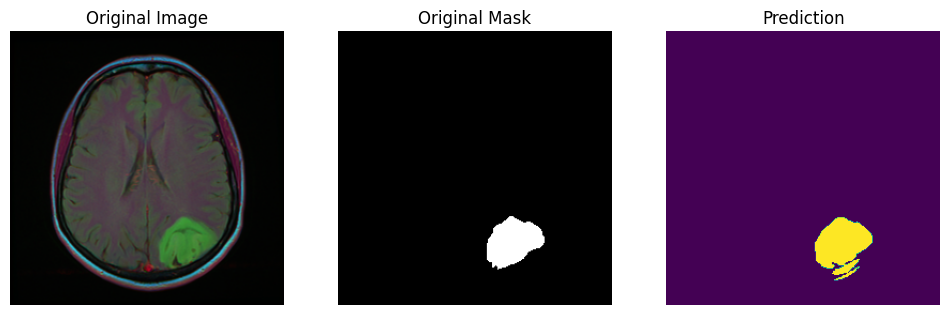

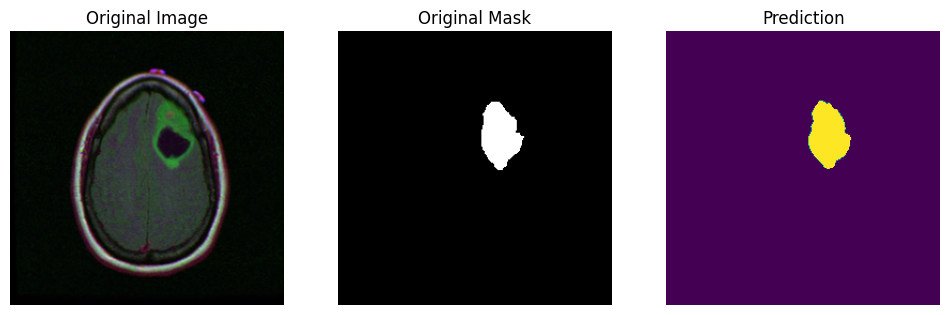

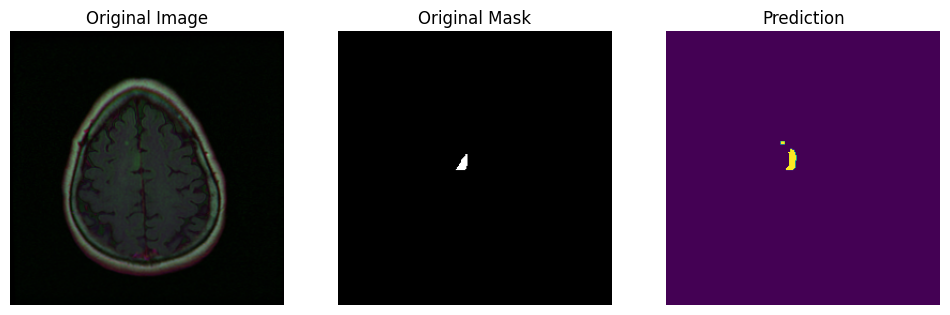

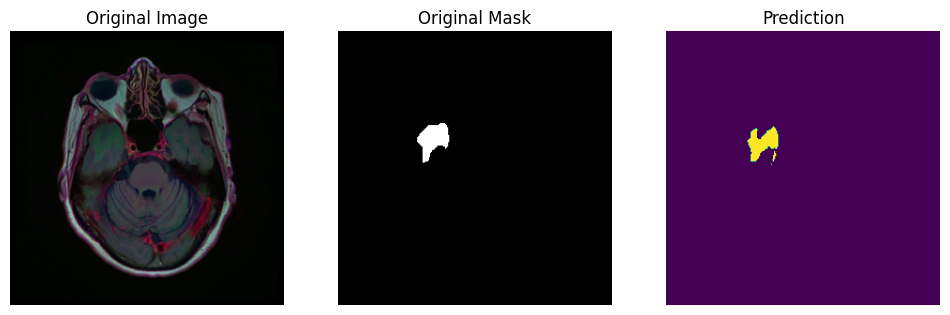

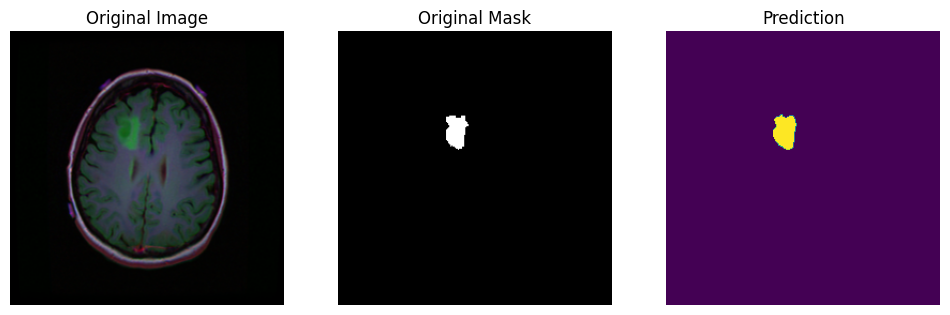

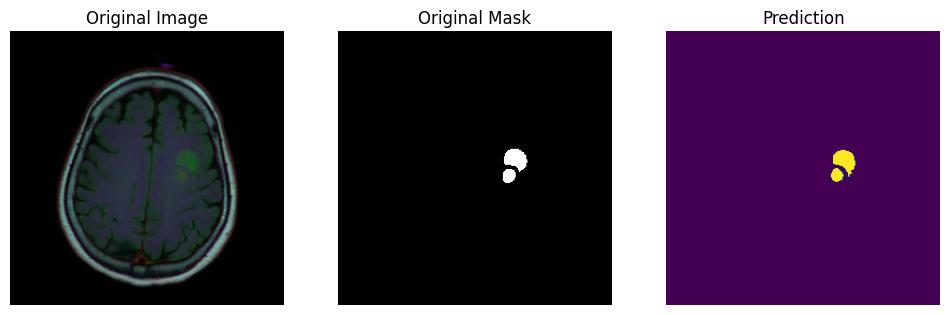

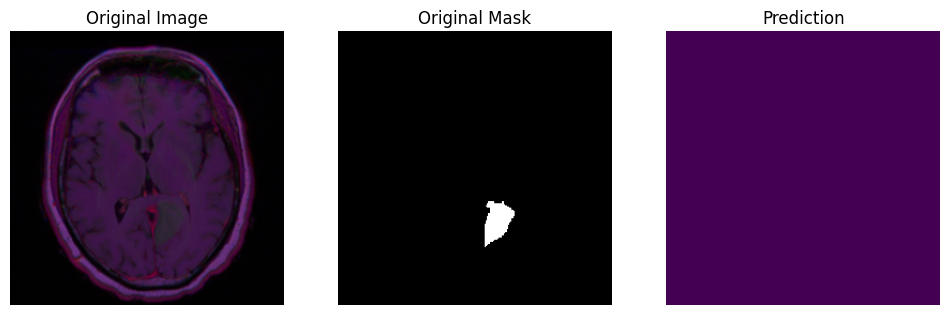

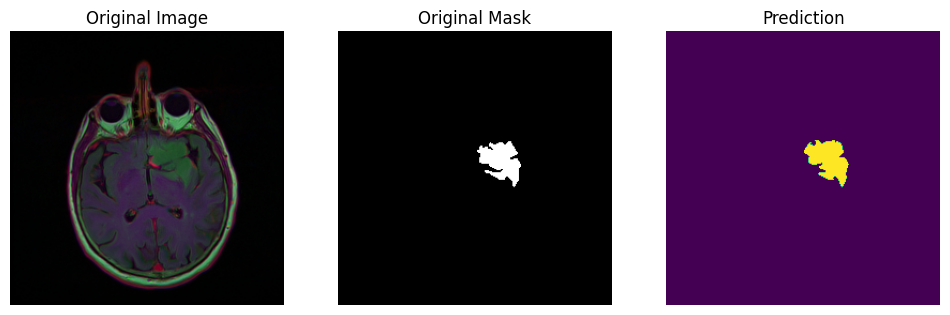

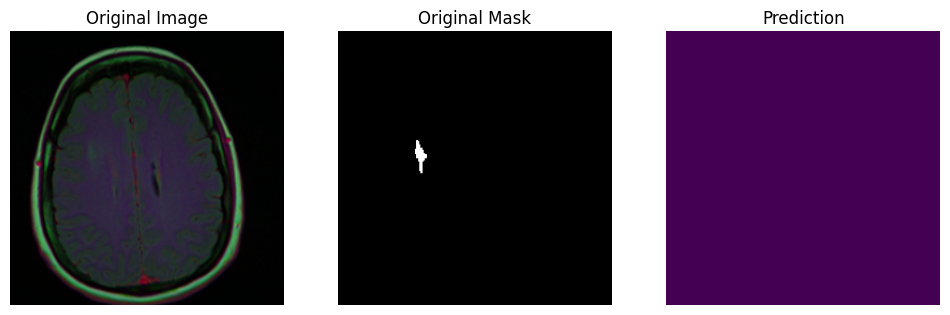

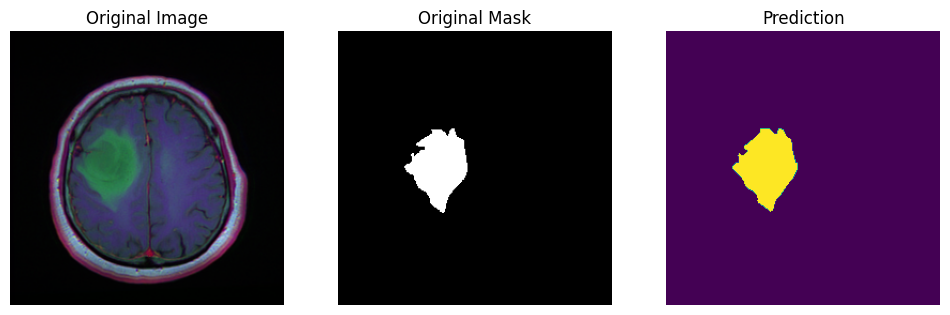

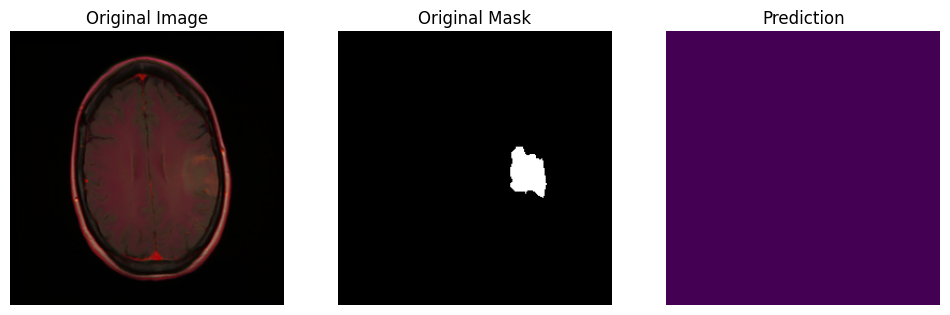

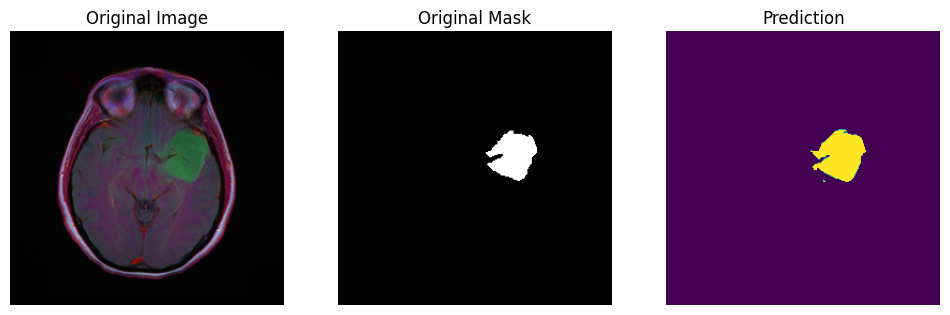

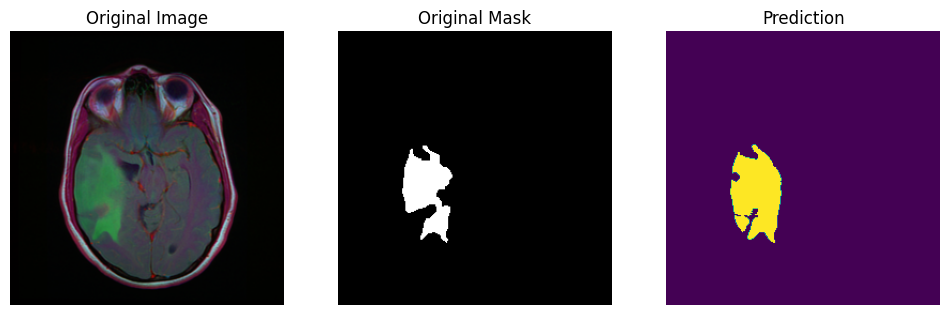

In [9]:
# import random
# random.seed(42)
# rindex = random.sample(range(0,len(test_df.index)),20)
# fweb_index = [] 
masks_paths = sorted(glob('test_images/*_mask*'))

model.eval()
for masks_path in masks_paths:
    images_path = masks_path.replace('_mask', '')
    img = cv2.imread(images_path)
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    mask = np.squeeze(cv2.imread(masks_path,cv2.IMREAD_GRAYSCALE))/255


    with torch.no_grad():
        img = torch.tensor(img, dtype=torch.float32).to(device)
        img = img.permute(0, 3, 1, 2)
        predicted_img = model(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    # Convert tensor to numpy and permute to (H, W, C)
    img_np = img.cpu().detach().numpy()
    img_np = np.squeeze(img_np)  # shape: (3, 256, 256)
    if img_np.ndim == 3 and img_np.shape[0] == 3:
        img_np = np.transpose(img_np, (1, 2, 0))  # (256, 256, 3)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    img_pre = (predicted_img>0.5).cpu().detach().numpy()
    img_pre = np.squeeze(img_pre)  # shape: (3, 256, 256)
    if img_pre.ndim == 3 and img_pre.shape[0] == 3:
        img_pre = np.transpose(img_pre, (1, 2, 0))  # (256, 256, 3)
    plt.imshow(img_pre)
    # plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()